In [1]:
import numpy as np
import random
import lib
from scipy.spatial import distance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from class_model import  create_model
from distill_dataset import ClassificationDataset, UNK_WORD, distill_collate_fun, emb_collate_fun
import lib
from train_distill import DistillModule
import distill_emb_model
import torch

In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
w2v_emb = lib.load_word_embeddings("dataset/corpus/am/am-w2v.vec", word_prob=.2)

In [4]:
target_words = sorted(np.random.choice(sorted(w2v_emb.keys()), size=10, replace=False))
total_words = sorted(w2v_emb.keys())
target_w2v = np.stack([w2v_emb[k] for k in total_words])
total_w2v = np.stack([w2v_emb[k] for k in total_words])
print(target_words)

['"ሰይጣንን', '___________________', 'ሊሰነዘርብን', 'ሰላማችንና', 'ሳይቆጠርበት', 'ስለተነካበት', 'በተወደደበት', 'ተገንብቶላቸው', 'የሚጎለው', 'የዘፋኙ']


In [5]:
# sims = []
# for k, kword in enumerate(target_words):
#     distances = distance.cdist([target_w2v[k]], target_w2v, "cosine")[0]
#     min_index = np.argmin(distances)
#     sorted_index = distances.argsort()
#     distances[sorted_index[0]]
#     sim_vecs = np.stack([total_w2v[sorted_index[i]] for i in range(20)])
#     sims.append(sim_vecs)

# simsx = np.concatenate(sims)
# pca = PCA(n_components=2)
# x = pca.fit_transform(simsx)

In [6]:
# # plt.scatter(x[:, 0], x[:, 1])
# fig, ax = plt.subplots()
# cm = plt.get_cmap('gist_rainbow')
# ax.set_prop_cycle(color=[cm(1.*i/len(sims)) for i in range(len(sims))])
# for g in range(len(sims)):
#     a, b = g * 10, g * 10 + 10
#     ax.scatter(x[a:b, 0], x[a:b, 1])
# plt.show()

In [9]:
model = distill_emb_model.create_am_distill_emb("data/am-charset.txt", 0.0, model_size="small", study=True).eval()

In [10]:
checkpoint = torch.load("saves/am-small/epoch=127-val_loss=0.00000-val_f1=0.00000.ckpt")
state = {k[6:]:v for i, (k, v) in enumerate(checkpoint['state_dict'].items())}
model.load_state_dict(state)
model=model.eval()

In [11]:

with torch.no_grad():
    total_d2, total_d1, total_cnn = lib.predict(model, total_words, "data/am-charset.txt")
    target_d2, target_d1, target_cnn = lib.predict(model, target_words, "data/am-charset.txt")

embedding_list = [
    [target_w2v, total_w2v],
    [target_d2.numpy(), total_d2.numpy()],
    [target_d1.numpy(), total_d1.numpy()],
    [target_cnn.numpy(), total_cnn.numpy()],
]

In [12]:
plot_xs = []
for idx, (target_emb, total_emb) in enumerate(embedding_list):
    sims = []
    for k, kword in enumerate(target_words):
        distances = distance.cdist([target_emb[k]], total_emb, "cosine")[0]
        min_index = np.argmin(distances)
        sorted_index = distances.argsort()
        distances[sorted_index[0]]
        sim_vecs = np.stack([total_emb[sorted_index[i]] for i in range(20)])
        sims.append(sim_vecs)

    simsx = np.concatenate(sims)
    pca = PCA(n_components=2)
    x = pca.fit_transform(simsx)
    plot_xs.append(x)

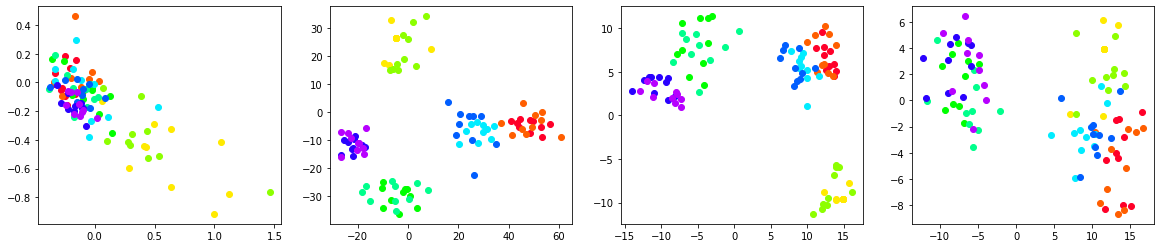

In [13]:
fig, axs = plt.subplots(1, 4)
fig.set_figwidth(20)
cm = plt.get_cmap('gist_rainbow')
for ix, ax in enumerate(axs):
    x = plot_xs[ix]
    ax.set_prop_cycle(color=[cm(1.*i/len(sims)) for i in range(len(sims))])
    for g in range(len(sims)):
        a, b = g * 10, g * 10 + 10
        ax.scatter(x[a:b, 0], x[a:b, 1])
plt.show()